In [1]:
import os
import time
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tf.__version__

'2.1.0'

In [9]:
"""
content_path : path where the content image is located
style_path :  path where the style image is located

"""
content_path = "content images/Mona_Lisa.jpg"
style_path = "style images/Constructivism.jpg"

In [10]:
#VGG model takes images as BGR format instead of RGB format so it needed to be preprocess first

In [11]:
"""
  function to get image as a numpy array
  Arguments:
    img_path: Path to the image to load
  Returns:
    image as a numpy array

"""


def get_image( img_path, max_resolution):
        max_dimension = max_resolution
        img = Image.open(img_path)
        long = max(img.size)
        scale = max_dimension / long
        # Resizing the image and converting it to RGB so all image types are usable
        img = img.convert("RGB")
        img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.ANTIALIAS)
        img = img_to_array(img)
        # We need to broadcast the image array such that it has a batch dimension
        img = np.expand_dims(img, axis=0)
        return img

In [12]:
"""
  preprocess raw images to make it suitable to be used by VGG19 model
  Returns:
    processed image that can be feed to VGG19 model.
"""
def preprocess_image(path):
        
  return tf.keras.applications.vgg19.preprocess_input(path)
        

In [13]:
content_img_arr = get_image(content_path,512)

In [14]:
style_img_arr = get_image(style_path,512)

In [15]:
content_img_arr.shape

(1, 512, 329, 3)

In [16]:
processed_content_image = preprocess_image(content_img_arr)

In [17]:
processed_style_image = preprocess_image(style_img_arr)

In [18]:
vgg_mean = [123.68, 116.779, 103.939]

In [19]:
 """
  Unprocesses images for display
  Arguments:
    processed_img: Image processed in vgg19 format
  Returns:
    An unprocessed image as a numpy array
  """


def deprocess_image(processed_img):
 
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  x[:, :, 0] += vgg_mean[2]
  x[:, :, 1] += vgg_mean[1]
  x[:, :, 2] += vgg_mean[0]
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [20]:
"""
list of layers to be considered to  extract content and style of images.
Here "block4_conv2" is used to extract content, alternatively "bolck5_conv2" can be used.

"""
content_layers = ['block4_conv2']
        # Style layer we are interested in
style_layers = [
            'block1_conv1',
            'block2_conv1',
            'block3_conv1',
            'block4_conv1',
            'block5_conv1',
            ]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [21]:
"""
  We load pretrained VGG19 model, trained on imagenet dataset
  Returns:
    returns a keras model that takes image inputs and outputs the style and
    content intermediate layers.  

"""


def create_vgg_model():
  vgg_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg_model.trainable = False
  # We don't need to (or want to) train any layers of our pre-trained vgg model, so we set it's trainable to false.
  # Get output layers corresponding to style and content layers
  style_outputs = [vgg_model.get_layer(name).output for name in style_layers]
        
  content_outputs = [vgg_model.get_layer(name).output for name in content_layers]
        
  output_layers = style_outputs + content_outputs
  # Build model
  return models.Model(vgg_model.input, output_layers)


In [22]:
model = create_vgg_model()

In [23]:
"""
  Gets the content loss of content and target
  Arguments:
    content: Content image
    target: Target image
   Returns:
    Content loss
"""
 
def content_loss(content, target):
  return tf.reduce_mean(tf.square(content - target))


In [24]:
"""
  Gets gram matrix of the input tensor
  Arguments:
    input_tensor: Tensor to calculate gram matrix
  Returns:
    Gram matrix of the tensor
"""
  
def gram_matrix( input_tensor):
  num_channels = int(input_tensor.shape[-1])
  # if input tensor is a 3D array of size Nh x Nw X Nc
  # we reshape it to a 2D array of Nc x (Nh*Nw)
  input_vectors = tf.reshape(input_tensor, [-1, num_channels])
  num_vectors = tf.shape(input_vectors)[0]
  gram = tf.matmul(input_vectors, input_vectors, transpose_a=True)
  return gram / tf.cast(num_vectors, tf.float32)


In [25]:
"""
  Gets the style loss between the style and the target
  Arguments:
    style: Style image
    gram_target: Gram matrix of the target image
  Returns:
    total style loss as scaled squared difference between the gram matricies
"""

#derived from refrences
def style_loss(style, gram_target):

        
  gram_style = gram_matrix(style)

        
  return tf.reduce_mean(tf.square(gram_style - gram_target))


In [26]:
"""
Get the style and content feature representations (from our specified intermediate layers)   
Function will run images through the vgg19 model to get activations
  Arguments:
    content_and_style_class: Instance of ContentAndStyleImage
  Returns:
    returns the style features and the content features.
"""

def get_feature_representations():
        

  content_image = processed_content_image
        
  style_image = processed_style_image 
        
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)

   # Get the style and content feature representations from our model
  style_features = [style_layer[0]
                          for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0]
                            for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

In [27]:
"""
  Computes the total loss
  Arguments:
    loss_weights: The weights of each contribution of each loss function.
    init_image: Initial base image.
    gram_style_features: Precomputed gram matrices corresponding to the
    defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of interest.
  Returns:
    returns the total loss, style loss, content loss, and variational loss
"""


def compute_loss(loss_weights, init_image, gram_style_features,
                      content_features):
  
  style_weight, content_weight = loss_weights
  # Feed our init image through our model. This will give us the content and
  # style representations at our desired layers.
  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  total_style_score = 0
  total_content_score = 0
 
  averge_style_weight = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    
     total_style_score += averge_style_weight * style_loss(comb_style[0], target_style)

  # content losses from all layers
  average_content_weight = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features,
                                                content_output_features):
    total_content_score += average_content_weight * content_loss(comb_content[0], target_content)
        
  total_style_score *= style_weight
  total_content_score *= content_weight

  # Get total loss
  total_loss = total_style_score + total_content_score 
  
  return total_loss, total_style_score, total_content_score


In [28]:
"""
  Computes gradients of the total loss
    Arguments:
      config: Dict object containing all arguments of compute_loss func
    Returns:
      Gradient of the losses and all of the losses
  
"""


def compute_gradients(config):
  with tf.GradientTape() as tape:
    all_loss = compute_loss(**config)
        # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, config['init_image']), all_loss

In [29]:
""" In original paper, the initial stylized image is random matrix of same size as that of content image
   but in later images content image was used instead on random values for first stylized image
   because it proved to help to stylize faster
"""

' In original paper, the initial stylized image is random matrix of same size as that of content image\n   but in later images content image was used instead on random values for first stylized image\n   because it proved to help to stylize faster\n'

In [30]:
"""
  Function that runs the nst
    Arguments:
      content_and_style_class: Instance of ContentAndStyleImage
      num_iterations: Number of iterations to optimize image
      content_weight: Weight to place on the content loss
      style_weight: Weight to place on the style loss
      
    returns:
      Best optimized image and best loss
"""




def run_style_transfer( num_iterations,
                           content_weight,
                           style_weight               
                       ):
  
  
  for layer in model.layers:
    layer.trainable = False

  # Get the style and content feature representations
  style_features, content_features = get_feature_representations()
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # Initially set content image as our base output image
  init_image = processed_content_image
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  # Here Adam Optimizer is used to optimize the loss, but in paper LBFGS is recommended.

  opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
  

  # Store our best result
  best_loss, best_img = float('inf'), None

  
  loss_weights = (style_weight, content_weight)
 
  config = {
            'loss_weights': loss_weights,
            'init_image': init_image,
            'gram_style_features': gram_style_features,
            'content_features': content_features,
        }

        
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means

  imgs = []


  for i in range(num_iterations):
    
    grads, all_loss = compute_gradients(config)
    loss, _, _ = all_loss
    opt.apply_gradients([(grads, init_image)])
    # Clip image to be in range 0-255 
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    if i%10 == 0:             
    #printing every 10th Iteration and loss
      print("Iteration ",i)
      print("LOSS= {0}".format(loss))
    if loss < best_loss:
    # Update best loss and best image from total loss.
      best_loss = loss
      best_img = deprocess_image(init_image.numpy())
    if i % 100 == 0:
      imgs.append(deprocess_image((init_image.numpy())))

  plt.imshow(best_img)
  
  return best_img, best_loss

Iteration  0
LOSS= 8567074586624.0
Iteration  10
LOSS= 1892947722240.0
Iteration  20
LOSS= 1186178400256.0
Iteration  30
LOSS= 875415732224.0
Iteration  40
LOSS= 702856822784.0
Iteration  50
LOSS= 592091545600.0
Iteration  60
LOSS= 508049784832.0
Iteration  70
LOSS= 445765451776.0
Iteration  80
LOSS= 397457883136.0
Iteration  90
LOSS= 358137462784.0


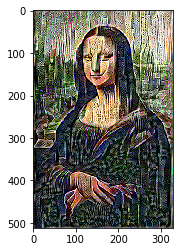

In [31]:
a,b = run_style_transfer(num_iterations=100,
                           content_weight=1e-1,
                           style_weight=1e2,
                           )

In [32]:
"""
  Function to plot Content Image, Style Image and Generated style transfer Image
  
"""

def plot():
  plt.figure(figsize=(30,30))
  plt.subplot(5,5,1)
  plt.title("Content Image",fontsize=20)
  img_cont = load_img(content_path)
  plt.imshow(img_cont)

  plt.subplot(5,5,1+1)
  plt.title("Style Image",fontsize=20)
  img_style = load_img(style_path)
  plt.imshow(img_style)

  plt.subplot(5,5,1+2)
  plt.title("Final Image",fontsize=20)
  plt.imshow(a)

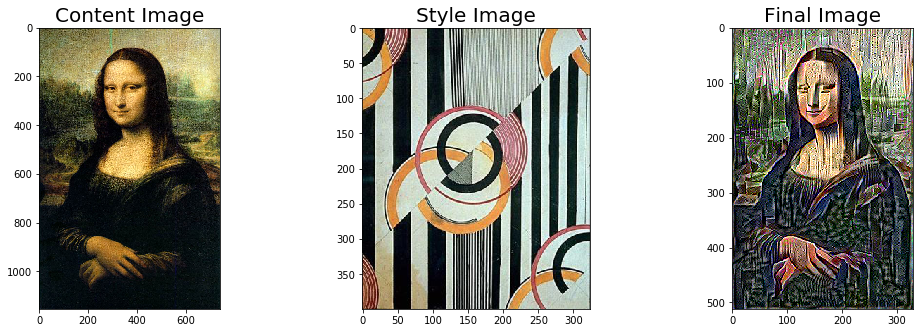

In [33]:
plot()